# Two-View 3D Reconstruction**

# **Step 1: Feature Matching**

In [ ]:
# Download data from Google Drive
import gdown
gdown.download_folder(id="1ROQl0NTBnxMjLrO5qISyxcTCJUPSMsRS", quiet=True, use_cookies=False)


['/content/project3/feature_points.npz',
 '/content/project3/image1.jpg',
 '/content/project3/image2.jpg',
 '/content/project3/intrinsics.npz',
 '/content/project3/monument_reconstruction.gif']

In [ ]:
def display_matches(img1, img2, pts1, pts2):
    """
    Visualize the matching points between two images.

    Input:
        img1: Image 1 in numpy array format.
        img2: Image 2 in numpy array format.
        pts1: Matched points in Image 1 (numpy array of shape Nx2).
        pts2: Matched points in Image 2 (numpy array of shape Nx2).
    """
    if len(img1.shape) == 3 and img1.shape[2] == 3:
        img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    else:
        img1_rgb = img1
        img2_rgb = img2

    h1, w1 = img1_rgb.shape[:2]
    h2, w2 = img2_rgb.shape[:2]
    combined_width = w1 + w2
    combined_height = max(h1, h2)
    combined_img = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)

    combined_img[:h1, :w1] = img1_rgb
    combined_img[:h2, w1:w1+w2] = img2_rgb

    plt.figure(figsize=(8, 5))
    plt.imshow(combined_img)

    for i in range(len(pts1)):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        x2 = x2 + w1
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=.5, alpha=0.5)



    plt.axis('off')
    plt.title('Matching Points with Connecting Lines')
    plt.tight_layout()
    plt.show()

In [ ]:
def load_data(image1_path, image2_path,npz_path):

    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)


    data = np.load(npz_path)
    pts1 = data['pts1']
    pts2 = data['pts2']
    return img1, img2,pts1, pts2

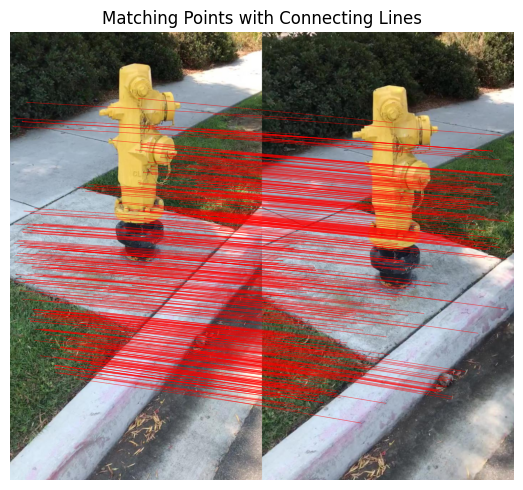

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image1_path = '/content/project3/image1.jpg'
image2_path = '/content/project3/image2.jpg'
npz_path = '/content/project3/feature_points.npz'
intrinsics = np.load('/content/project3/intrinsics.npz')
K1 = intrinsics['K1']
K2 = intrinsics['K2']

img1, img2,pts1, pts2 = load_data(image1_path, image2_path,npz_path)

display_matches(img1, img2, pts1, pts2)

# **Step 2: Fundamental Matrix Estimation and RANSAC**

In [ ]:
import numpy as np

def estimate_Fmatrix(img1_pts, img2_pts):
    """
    Estimate the Fundamental Matrix using matched points from two images.

    Input:
        img1_pts: Matched points from Image 1 (numpy array of shape Nx2).
        img2_pts: Matched points from Image 2 (numpy array of shape Nx2).

    Output:
        F: Estimated Fundamental Matrix (3x3 numpy array).
    """
    img1_pts = np.asarray(img1_pts)
    img2_pts = np.asarray(img2_pts)

    mean1 = np.mean(img1_pts, axis=0)
    mean2 = np.mean(img2_pts, axis=0)
    std1 = np.std(img1_pts)
    std2 = np.std(img2_pts)

    T1 = np.array([[1/std1, 0, -mean1[0]/std1],
                   [0, 1/std1, -mean1[1]/std1],
                   [0, 0, 1]])

    T2 = np.array([[1/std2, 0, -mean2[0]/std2],
                   [0, 1/std2, -mean2[1]/std2],
                   [0, 0, 1]])

    img1_pts_norm = (T1 @ np.hstack((img1_pts, np.ones((img1_pts.shape[0], 1)))).T).T
    img2_pts_norm = (T2 @ np.hstack((img2_pts, np.ones((img2_pts.shape[0], 1)))).T).T

    A = np.zeros((len(img1_pts), 9))
    for i, (p1, p2) in enumerate(zip(img1_pts_norm, img2_pts_norm)):
        A[i] = [p2[0] * p1[0], p2[0] * p1[1], p2[0],
                p2[1] * p1[0], p2[1] * p1[1], p2[1],
                p1[0], p1[1], 1]

    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    U, S, Vt = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vt

    F = T2.T @ F @ T1

    return F

In [ ]:
def ransac(pts1, pts2, iterations=4000, threshold=0.001):
    """
    Apply RANSAC to estimate the Fundamental Matrix robustly.

    Input:
        pts1: Points from Image 1 (numpy array of shape Nx2).
        pts2: Points from Image 2 (numpy array of shape Nx2).
        iterations: Number of RANSAC iterations (int).
        threshold: Distance threshold

    Output:
        img1_inliers: Inliers from Image 1 (numpy array of shape Mx2).
        img2_inliers: Inliers from Image 2 (numpy array of shape Mx2).
        best_F: Best Fundamental Matrix found (3x3 numpy array).
    """

    best_F = None
    max_inliers = 0
    inlier_pts1 = None
    inlier_pts2 = None

    for _ in range(iterations):
        idx = np.random.choice(len(pts1), 8, replace=False)
        sample_pts1 = pts1[idx]
        sample_pts2 = pts2[idx]

        F = estimate_Fmatrix(sample_pts1, sample_pts2)

        inliers = []
        for i, (p1, p2) in enumerate(zip(pts1, pts2)):
            p1_h = np.array([p1[0], p1[1], 1])
            p2_h = np.array([p2[0], p2[1], 1])

            error = p2_h.T @ F @ p1_h
            if abs(error) < threshold:
                inliers.append(i)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_F = F
            inlier_pts1 = pts1[inliers]
            inlier_pts2 = pts2[inliers]

    return inlier_pts1, inlier_pts2, best_F

In [ ]:
img1_points, img2_points, F = ransac(pts1, pts2)
print("Fundamental Matrix:", F)
print("Determinant", np.linalg.det(F))
print("Rank", np.linalg.matrix_rank(F))

Fundamental Matrix: [[ 2.42863384e-08 -2.60724907e-07 -3.37037088e-04]
 [ 4.86790987e-07  9.46152620e-08 -2.64548425e-03]
 [ 3.16739358e-04  2.51766832e-03  1.75967792e-01]]
Determinant 6.481414086282048e-29
Rank 2


# **Draw epipolar lines**

In [ ]:
import random
def compute_epipolar_lines_manual(pts, F):
    """
    Compute epipolar lines for given points using the Fundamental Matrix.

    Input:
        pts: Points in homogeneous coordinates (numpy array of shape Nx2).
        F: Fundamental Matrix (3x3 numpy array).

    Output:
        lines: Epipolar lines in homogeneous form (Nx3 numpy array).

    Comments:
        - Converts points to homogeneous coordinates.
        - Computes lines using the Fundamental Matrix.
    """
    pts_h = np.hstack((pts, np.ones((pts.shape[0], 1))))

    lines = F @ pts_h.T

    return lines.T

def draw_epipolar_lines_img1_points_img2_lines(img1, img2, inliers1, inliers2, F):
    """
    Draw epipolar lines on the second image for points from the first image.

    Input:
        img1: Image 1 in numpy array format.
        img2: Image 2 in numpy array format.
        pts1: Points in Image 1 (numpy array of shape Nx2).
        F: Fundamental Matrix (3x3 numpy array).

    """

    if len(pts1) > 30:
        sampled_indices = np.random.choice(len(pts1), 30, replace=False)
        sampled_pts1 = pts1[sampled_indices]
    else:
        sampled_pts1 = pts1

    lines = compute_epipolar_lines_manual(sampled_pts1, F)

    if len(img1.shape) == 3 and img1.shape[2] == 3:
        img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    else:
        img1_rgb = img1

    if len(img2.shape) == 3 and img2.shape[2] == 3:
        img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    else:
        img2_rgb = img2

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1_rgb)
    plt.scatter(sampled_pts1[:, 0], sampled_pts1[:, 1], c='red', marker='o', label="Sampled Points", s=15)
    plt.title("Viewpoint 1 (Sampled Points)")
    plt.legend(loc="upper left")

    plt.subplot(1, 2, 2)
    plt.imshow(img2_rgb)
    h, w = img2.shape[:2]
    for line in lines:
        color = [random.random(), random.random(), random.random()]
        a, b, c = line
        x0, y0 = 0, int(-c / b) if b != 0 else 0
        x1, y1 = w, int(-(c + a * w) / b) if b != 0 else h
        plt.plot([x0, x1], [y0, y1], color=color, linewidth=1)

    plt.title("Viewpoint 2 (Epipolar Lines for Sampled Points)")
    plt.tight_layout()
    plt.show()

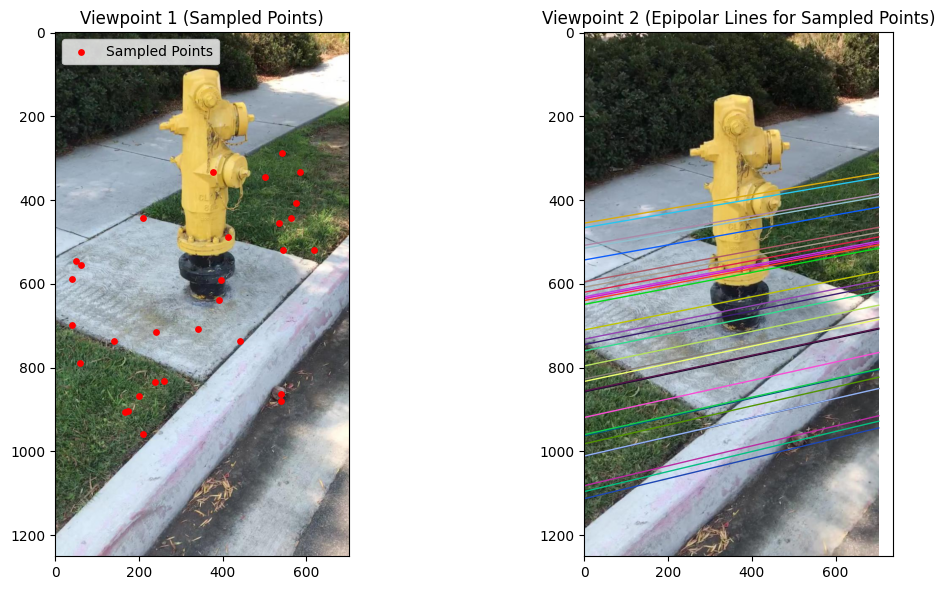

In [ ]:
#Draw epipolar lines based on the fundamental matrix
draw_epipolar_lines_img1_points_img2_lines(img1, img2, img1_points, img2_points, F)

# **Step 3: Estimate Essential Matrix E**





In [ ]:
import numpy as np

def estimate_Essentialmatrix(K1, K2, F):
    """
    Estimate the Essential Matrix using camera intrinsics and the Fundamental Matrix.

    Input:
        K1: Intrinsic matrix of Camera 1 (3x3 numpy array).
        K2: Intrinsic matrix of Camera 2 (3x3 numpy array).
        F: Fundamental Matrix (3x3 numpy array).

    Output:
        E: Estimated Essential Matrix (3x3 numpy array).

    Comments:
        - Computes the Essential Matrix as E = K2.T @ F @ K1.
    """
    E = K2.T @ F @ K1

    U, S, Vt = np.linalg.svd(E)
    S = [1, 1, 0]
    E = U @ np.diag(S) @ Vt

    return E


In [ ]:
E = estimate_Essentialmatrix(K1, K2, F)
print("Essential Matrix E:",E )

Essential Matrix E: [[ 0.01203562 -0.12475809 -0.19539588]
 [ 0.23081681  0.03496954 -0.95363685]
 [ 0.24078182  0.95903171  0.06686397]]


# **Step 4: Extracting Poses form E matrix**



In [ ]:
def get_RTset(E):
    """
    Extract possible sets of rotation (R) and translation (T) from the Essential Matrix.

    Input:
        E: Essential Matrix (3x3 numpy array).

    Output:
        R: List of possible rotation matrices (4x 3x3 numpy arrays).
        T: List of possible translation vectors (4x 3x1 numpy arrays).

    Comments:
        - Uses SVD decomposition of the Essential Matrix.
        - Constructs four possible (R, T) pairs and ensures valid rotations
    """

    U, _, Vt = np.linalg.svd(E)

    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1

    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    T = U[:, 2]

    if np.linalg.det(R1) < 0:
        R1 *= -1
    if np.linalg.det(R2) < 0:
        R2 *= -1

    R_set = [R1, R2, R1, R2]
    T_set = [T, T, -T, -T]

    return R_set, T_set

# **Step 5: Linear Triangulation**


In [ ]:
def linear_triangulation(R_Set, T_Set, pt1, pt2, k):
    """
    Perform linear triangulation to estimate 3D points.

    Input:
        R_Set: List of possible rotation matrices (4x 3x3 numpy arrays).
        T_Set: List of possible translation vectors (4x 3x1 numpy arrays).
        pt1: Points in Image 1 (numpy array of shape Nx2).
        pt2: Points in Image 2 (numpy array of shape Nx2).
        k: Camera intrinsic matrix (3x3 numpy array).

    Output:
        points_3d_set: List of 3D points for each (R, T) pair.

    Comments:
        - Triangulates 3D points for each (R, T) pair.
"""
    points_3d_set = []

    P1 = k @ np.hstack((np.eye(3), np.zeros((3, 1))))

    for R, T in zip(R_Set, T_Set):
        P2 = k @ np.hstack((R, T.reshape(-1, 1)))

        points_3d = []

        for i in range(pt1.shape[0]):
            x1 = np.array([pt1[i, 0], pt1[i, 1], 1.0])
            x2 = np.array([pt2[i, 0], pt2[i, 1], 1.0])

            A = np.zeros((4, 4))
            A[0] = x1[0] * P1[2] - P1[0]
            A[1] = x1[1] * P1[2] - P1[1]
            A[2] = x2[0] * P2[2] - P2[0]
            A[3] = x2[1] * P2[2] - P2[1]

            _, _, Vt = np.linalg.svd(A)
            X = Vt[-1]
            X /= X[3]

            points_3d.append(X[:3])

        points_3d_set.append(np.array(points_3d))

    return points_3d_set

# **Step 6: Cheriality condition**

In [ ]:
# Function to select the best pose (R, T) based on the chirality condition
def extract_pose(R_set, T_set, pts_3d_set):
    """
    Select the best pose (R, T) that satisfies the chirality condition.

    Input:
        R_set: List of possible rotation matrices (4x 3x3 numpy arrays).
        T_set: List of possible translation vectors (4x 3x1 numpy arrays).
        pts_3d_set: List of 3D point sets for each (R, T) pair.

    Output:
        R_best: Best rotation matrix (3x3 numpy array).
        T_best: Best translation vector (3x1 numpy array).
        X_best: Best 3D points (Nx3 numpy array).
        index: Index of the best (R, T) pair.

    """
    max_depth_count = -1
    R_best, T_best, X_best = None, None, None
    best_index = -1

    for i, (R, T, pts_3d) in enumerate(zip(R_set, T_set, pts_3d_set)):
        r3 = R[2, :]

        depth1 = pts_3d[:, 2]
        depth2 = (r3 @ pts_3d.T + T[2]).T

        depth_count = np.sum((depth1 > 0) & (depth2 > 0))

        if depth_count > max_depth_count:
            max_depth_count = depth_count
            R_best = R
            T_best = T
            X_best = pts_3d
            best_index = i

    return R_best, T_best, X_best, best_index

In [ ]:
def compute_cheriality(pt, r3, t):
    """
    Compute the chirality condition to determine if points are in front of the camera.

    Input:
        pt: 3D points (Nx3 numpy array).
        r3: Third row of the rotation matrix (1x3 numpy array).
        t: Translation vector (3x1 numpy array).

    Output:
        count_depth: Number of points with positive depth.

    """
    depth1 = pt[:, 2]

    depth2 = (r3 @ pt.T + t).T

    count_depth = np.sum((depth1 > 0) & (depth2 > 0))

    return count_depth


Best Rotation Matrix:
 [[ 0.99344521 -0.05822553  0.09836867]
 [ 0.05354893  0.99733595  0.04953287]
 [-0.10099068 -0.04394066  0.99391655]]
Best Translation Vector:
 [-0.97268238  0.18994074 -0.13345975]
Best Pose Index: 3


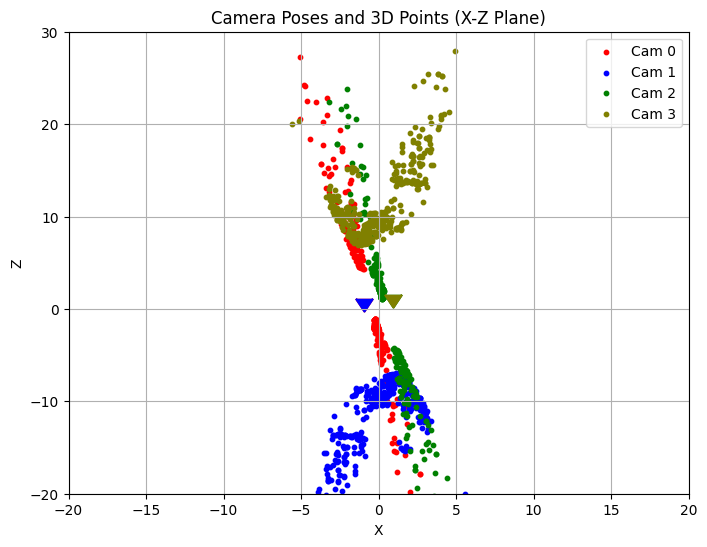

In [ ]:
import matplotlib as mpl
R_set, T_set = get_RTset(E)

#Linear Triangulation
point3D_set = linear_triangulation(R_set,T_set,img1_points,img2_points,K1)

#TO-DO: Plot all poses with 3D points as shown in figure

def plot_poses_with_points(R_set, T_set, pts_3d_set):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 6))

    colors = ['red', 'blue', 'green', 'olive']
    for i, (R, T, pts_3d) in enumerate(zip(R_set, T_set, pts_3d_set)):
        ax.scatter(pts_3d[:, 0], pts_3d[:, 2], s=10, color=colors[i], label=f'Cam {i}')

        camera_center = -R.T @ T
        t = mpl.markers.MarkerStyle(marker=mpl.markers.CARETDOWN)
        ax.scatter(camera_center[0], camera_center[2], marker = t, s = 150, color=colors[i])

    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 30)

    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_title('Camera Poses and 3D Points (X-Z Plane)')
    ax.legend()
    plt.grid()
    plt.show()



R_best, T_best, X_best, best_index = extract_pose(R_set, T_set, point3D_set)

print("Best Rotation Matrix:\n", R_best)
print("Best Translation Vector:\n", T_best)
print("Best Pose Index:", best_index)

# Plot all poses with 3D points
plot_poses_with_points(R_set, T_set, point3D_set)

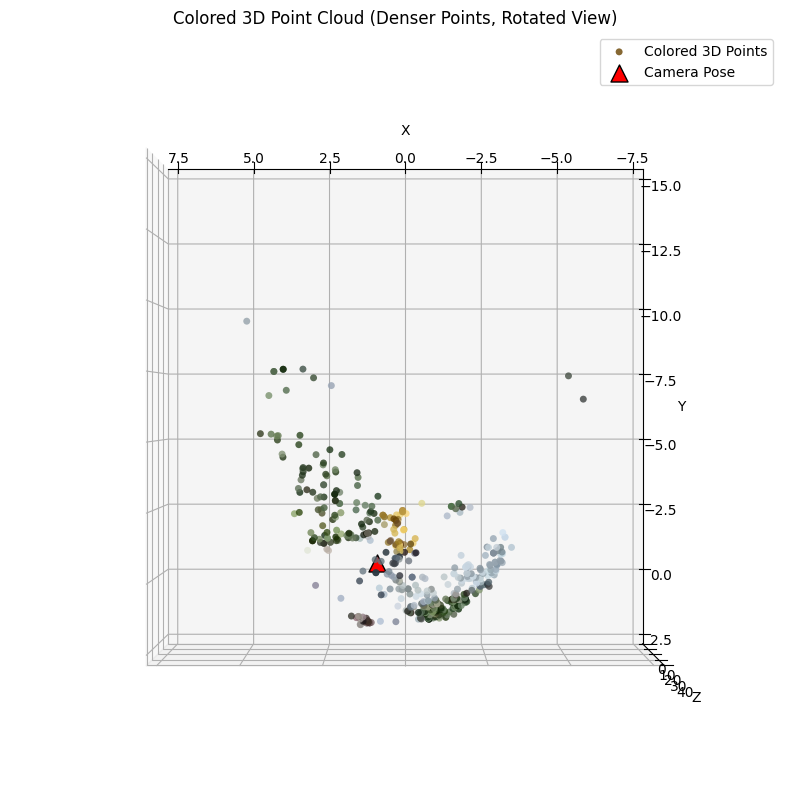

In [ ]:
 #Get pose of camera using chirality condition
R_best, T_best,X_ ,index= extract_pose(R_set,T_set,point3D_set)

def get_rgb_from_image(image, points_2d):
    points_2d = points_2d.astype(int)

    bgr_colors = image[points_2d[:, 1], points_2d[:, 0]]
    rgb_colors = bgr_colors[:, ::-1]

    colors = rgb_colors / 255.0

    return colors

def plot_3d_point_cloud_with_rgb_and_camera(points_3d, colors, R_best, T_best):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    x = points_3d[:, 0]
    y = points_3d[:, 1]
    z = points_3d[:, 2]

    ax.scatter(x, y, z, c=colors, marker='o', s=25, edgecolor='none', alpha=0.8, label="Colored 3D Points")

    camera_position = -R_best.T @ T_best
    ax.scatter(
        camera_position[0],
        camera_position[1],
        camera_position[2],
        c='red',
        marker='^',
        s=150,
        edgecolor='black',
        label="Camera Pose",
    )

    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-15, 2.5)
    ax.set_zlim(0, 40)

    ax.set_xticks(np.arange(7.5, -8, -2.5))
    ax.set_yticks(np.arange(2.5, -16, -2.5))
    ax.set_zticks(np.arange(0, 41, 10))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Colored 3D Point Cloud (Denser Points, Rotated View)")

    ax.legend()

    ax.view_init(elev=90, azim=90)

    plt.show()


colors = get_rgb_from_image(img1, img1_points)
plot_3d_point_cloud_with_rgb_and_camera(X_best, colors, R_best, T_best)